# Enhanced Holster Draw Analysis with Movement Traces

This notebook provides advanced analysis of holster draw data, including gun movement trace visualizations similar to MantisX's trace display.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import seaborn as sns
from datetime import datetime

In [2]:
# Load all session data
data_dir = Path("data/holster_draw_analysis")
files = sorted(list(data_dir.glob("*.json")))

all_sessions = []
for file in files:
    with open(file) as f:
        content = json.load(f)
        all_sessions.append(content)

print(f"Loaded {len(all_sessions)} sessions")
print(f"Date range: {files[0].stem} to {files[-1].stem}")

Loaded 14 sessions
Date range: 2025_06_25_session_29297738 to 2025_06_27_session_29319595


## Gun Movement Trace Visualization

This visualization shows the pitch and yaw movements of the gun during the draw, creating a trace similar to the MantisX display.

In [3]:
def plot_movement_trace(session_data, shot_index=0, figsize=(10, 8)):
    """Plot the gun movement trace for a specific shot"""
    shot = session_data['session']['shots'][shot_index]
    
    # Extract pitch and yaw data
    pitch = np.array(shot.get('pitch', []))
    yaw = np.array(shot.get('yaw', []))
    
    if len(pitch) == 0 or len(yaw) == 0:
        print(f"No pitch/yaw data available for shot {shot_index}")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color gradient for the trace
    points = np.array([yaw, pitch]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Color mapping: start (red) -> middle (cyan) -> end (yellow)
    colors = np.zeros((len(segments), 4))
    n = len(segments)
    
    # First third: red to cyan
    third = n // 3
    for i in range(third):
        t = i / third
        colors[i] = [1-t, t, t, 0.8]  # Red to cyan
    
    # Second third: cyan to green
    for i in range(third, 2*third):
        t = (i - third) / third
        colors[i] = [0, 1-t*0.5, 1-t, 0.8]  # Cyan to green
    
    # Last third: green to yellow
    for i in range(2*third, n):
        t = (i - 2*third) / (n - 2*third)
        colors[i] = [t, 1, 0, 0.8]  # Green to yellow
    
    # Create line collection
    lc = LineCollection(segments, colors=colors, linewidths=2)
    ax.add_collection(lc)
    
    # Add start and end markers
    ax.scatter(yaw[0], pitch[0], c='red', s=100, marker='o', zorder=5, label='Start')
    ax.scatter(yaw[-1], pitch[-1], c='yellow', s=100, marker='s', zorder=5, label='End')
    
    # Style the plot
    ax.set_facecolor('#2b2b2b')
    ax.grid(True, alpha=0.3, color='gray')
    ax.axhline(y=0, color='white', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='white', linewidth=0.5, alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('Yaw (degrees)', fontsize=12)
    ax.set_ylabel('Pitch (degrees)', fontsize=12)
    ax.set_title(f'Gun Movement Trace - Shot {shot_index + 1}\nTotal Time: {shot.get("holster_total_time", "N/A")}s', 
                fontsize=14, pad=20)
    
    # Set axis limits with some padding
    yaw_range = yaw.max() - yaw.min()
    pitch_range = pitch.max() - pitch.min()
    ax.set_xlim(yaw.min() - yaw_range*0.1, yaw.max() + yaw_range*0.1)
    ax.set_ylim(pitch.min() - pitch_range*0.1, pitch.max() + pitch_range*0.1)
    
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    return fig, ax

Session: 2025-06-25T18:48:34.258014+00:00
Drill: Holster Draw Analysis
Total shots: 10


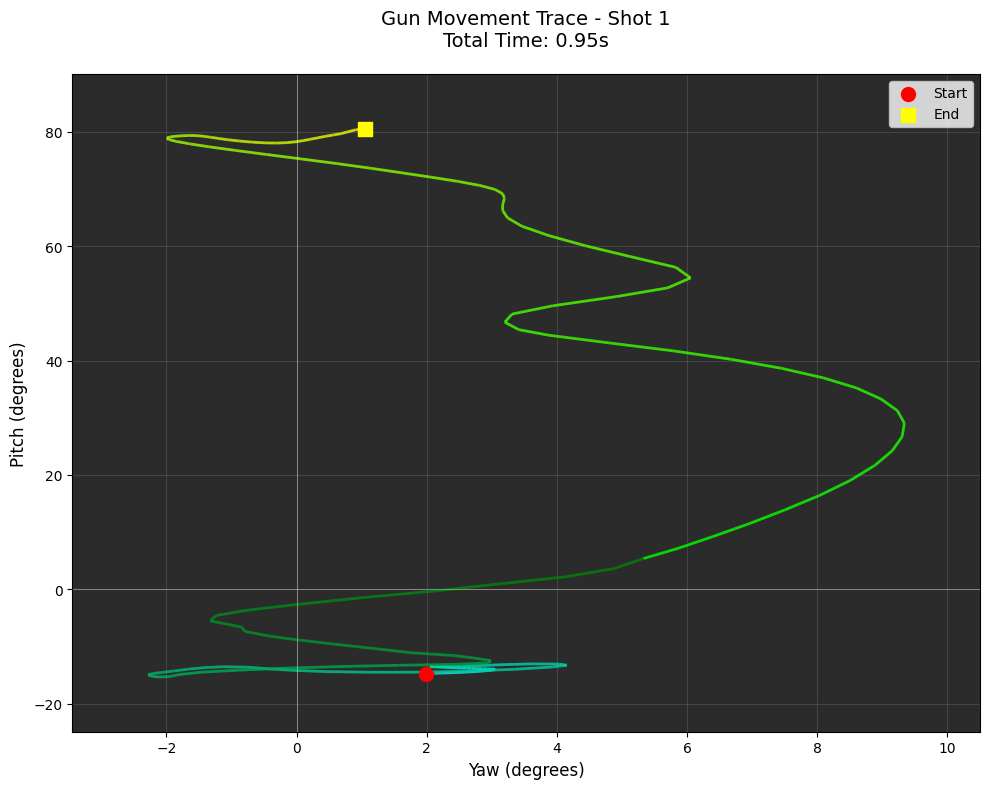

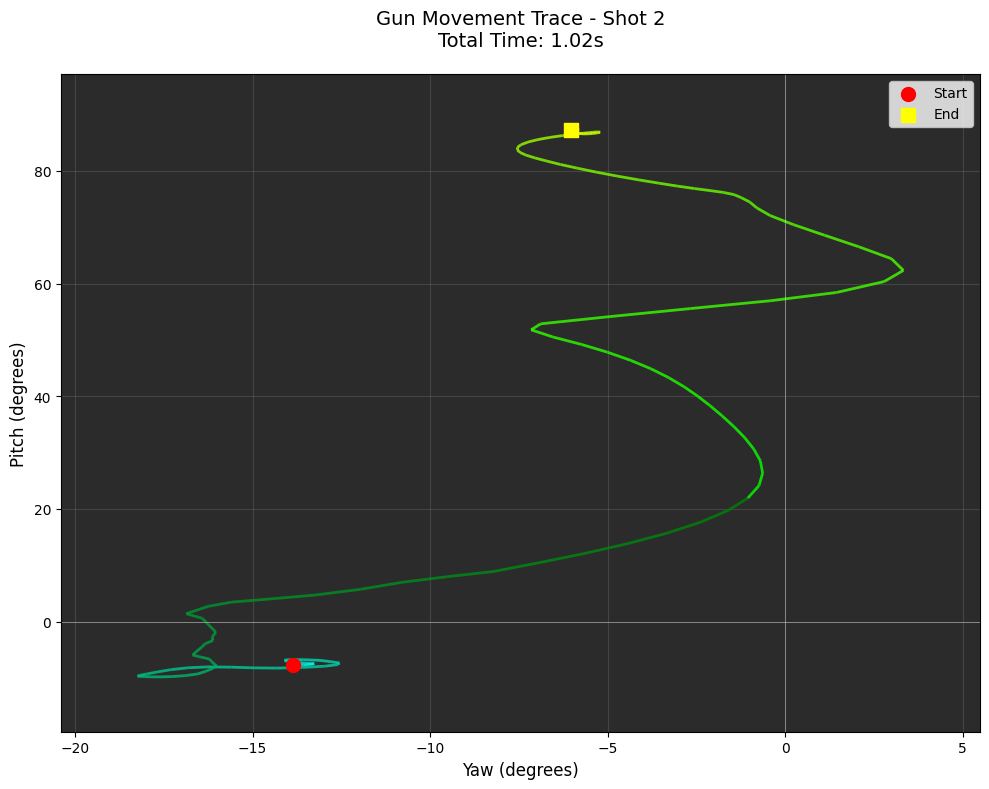

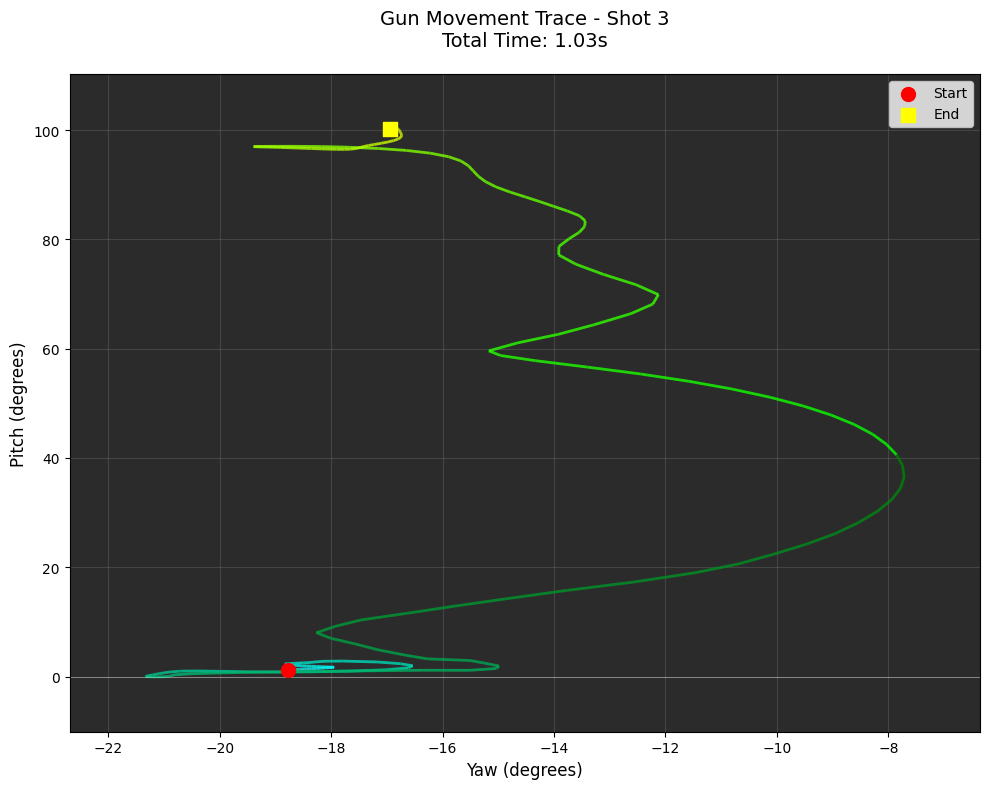

In [4]:
# Visualize movement traces for the first few shots of the first session
session = all_sessions[0]
print(f"Session: {session['session']['date']}")
print(f"Drill: {session['session']['drill_name']}")
print(f"Total shots: {len(session['session']['shots'])}")

# Plot first 3 shots
for i in range(min(3, len(session['session']['shots']))):
    plot_movement_trace(session, shot_index=i)
    plt.show()

## Movement Pattern Comparison

Compare movement patterns across multiple shots to identify consistency and areas for improvement.

In [6]:
def plot_overlay_traces(session_data, shot_indices=None, figsize=(12, 8)):
    """Overlay multiple shot traces for comparison"""
    if shot_indices is None:
        shot_indices = range(len(session_data['session']['shots']))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color palette for different shots
    colors = plt.cm.rainbow(np.linspace(0, 1, len(shot_indices)))
    
    for idx, shot_idx in enumerate(shot_indices):
        shot = session_data['session']['shots'][shot_idx]
        pitch = np.array(shot.get('pitch', []))
        yaw = np.array(shot.get('yaw', []))
        
        if len(pitch) > 0 and len(yaw) > 0:
            ax.plot(yaw, pitch, color=colors[idx], alpha=0.6, linewidth=2, 
                   label=f'Shot {shot_idx + 1} ({shot.get("holster_total_time", "N/A")}s)')
            # Mark start and end
            ax.scatter(yaw[0], pitch[0], color=colors[idx], s=50, marker='o', alpha=0.8)
            ax.scatter(yaw[-1], pitch[-1], color=colors[idx], s=50, marker='s', alpha=0.8)
    
    # Style
    ax.set_facecolor('#f0f0f0')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('Yaw (degrees)', fontsize=12)
    ax.set_ylabel('Pitch (degrees)', fontsize=12)
    ax.set_title('Movement Pattern Comparison', fontsize=14, pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig, ax

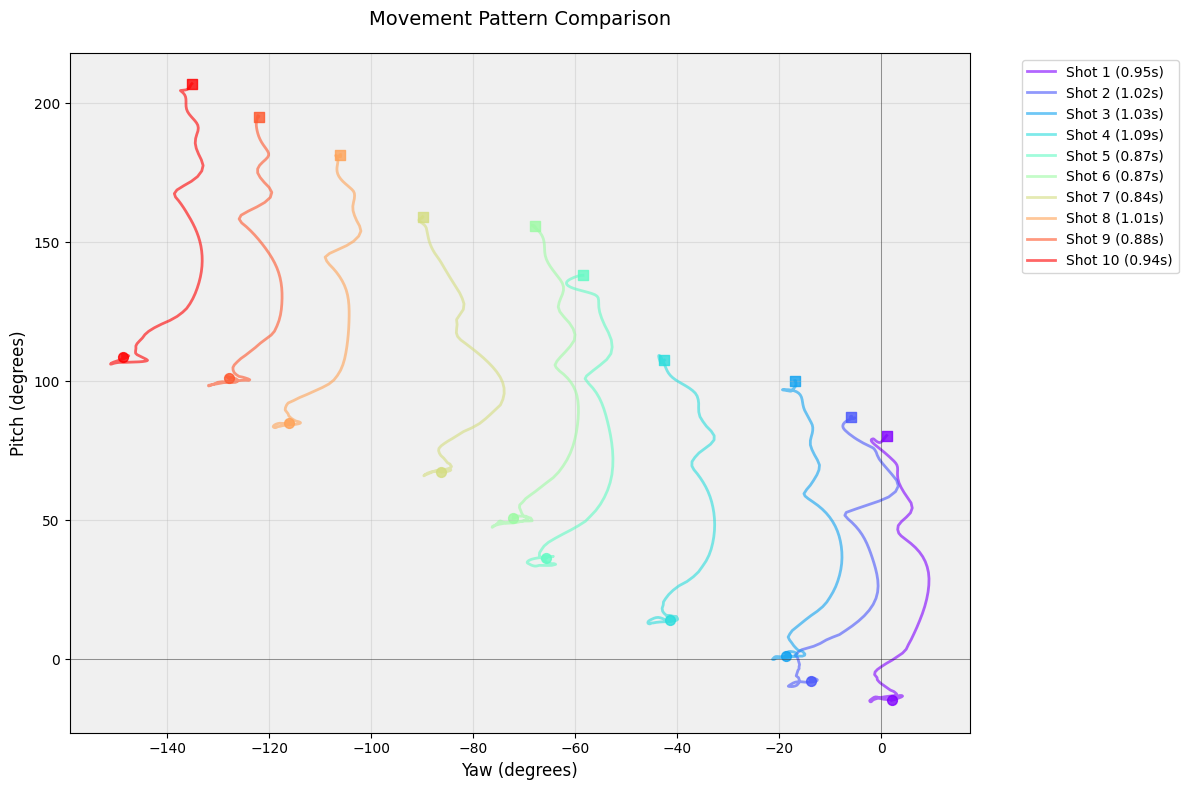

In [7]:
# Compare all shots from the first session
plot_overlay_traces(all_sessions[0])
plt.show()

## Movement Stability Analysis

Analyze the stability of movement by calculating variance and range of motion during different phases of the draw.

In [8]:
def analyze_movement_stability(session_data):
    """Analyze movement stability metrics across all shots"""
    stability_metrics = []
    
    for shot_idx, shot in enumerate(session_data['session']['shots']):
        pitch = np.array(shot.get('pitch', []))
        yaw = np.array(shot.get('yaw', []))
        
        if len(pitch) > 0 and len(yaw) > 0:
            # Calculate metrics
            metrics = {
                'shot_number': shot_idx + 1,
                'total_time': shot.get('holster_total_time', 0),
                'pitch_range': pitch.max() - pitch.min(),
                'yaw_range': yaw.max() - yaw.min(),
                'pitch_std': np.std(pitch),
                'yaw_std': np.std(yaw),
                'total_distance': np.sum(np.sqrt(np.diff(pitch)**2 + np.diff(yaw)**2)),
                'final_pitch': pitch[-1],
                'final_yaw': yaw[-1]
            }
            
            # Analyze final position stability (last 10% of movement)
            final_portion = int(len(pitch) * 0.1)
            if final_portion > 0:
                metrics['final_pitch_std'] = np.std(pitch[-final_portion:])
                metrics['final_yaw_std'] = np.std(yaw[-final_portion:])
            
            stability_metrics.append(metrics)
    
    return pd.DataFrame(stability_metrics)

In [9]:
# Analyze stability for all sessions
all_stability_data = []

for session in all_sessions:
    stability_df = analyze_movement_stability(session)
    stability_df['session_date'] = session['session']['date']
    all_stability_data.append(stability_df)

combined_stability = pd.concat(all_stability_data, ignore_index=True)
combined_stability['session_date'] = pd.to_datetime(combined_stability['session_date'])

print(f"Analyzed {len(combined_stability)} total shots")
combined_stability.head(10)

Analyzed 140 total shots


,shot_number,total_time,pitch_range,yaw_range,pitch_std,yaw_std,total_distance,final_pitch,final_yaw,final_pitch_std,final_yaw_std,session_date
0,1,0.95,95.801462,11.623770,37.253731,2.426132,123.901761,80.521805,1.049154,0.755382,0.894076,2025-06-25 18:48:34.258014+00:00
1,2,1.02,97.311067,21.570605,38.318653,5.374525,127.492571,87.229935,-6.026518,0.304134,0.282650,2025-06-25 18:48:34.258014+00:00
2,3,1.03,100.349471,13.619062,40.125425,3.005884,127.913023,100.246280,-16.949330,1.325791,0.272688,2025-06-25 18:48:34.258014+00:00
3,4,1.09,96.579111,13.097099,33.708767,2.865626,127.393754,107.610010,-42.538590,1.413502,0.463142,2025-06-25 18:48:34.258014+00:00
4,5,0.87,104.618045,16.817275,35.768626,4.581733,132.664901,138.155200,-58.494637,2.129786,1.381622,2025-06-25 18:48:34.258014+00:00
5,6,0.87,108.706050,16.916199,35.541344,4.414231,137.473375,155.735720,-67.950424,4.889527,1.124611,2025-06-25 18:48:34.258014+00:00
6,7,0.84,93.252890,16.710256,32.452939,3.326665,115.641771,159.273480,-89.896996,1.962148,0.548221,2025-06-25 18:48:34.258014+00:00
7,8,1.01,98.196870,17.194320,37.230739,5.140408,122.422032,181.553710,-106.019300,0.268664,0.371163,2025-06-25 18:48:34.258014+00:00
8,9,0.88,97.256796,14.418690,34.817925,3.536457,124.969855,195.238800,-122.061130,1.242237,0.136430,2025-06-25 18:48:34.258014+00:00
9,10,0.94,100.895370,18.141290,35.912240,6.172048,125.301723,207.097180,-135.143280,1.149337,0.755553,2025-06-25 18:48:34.258014+00:00


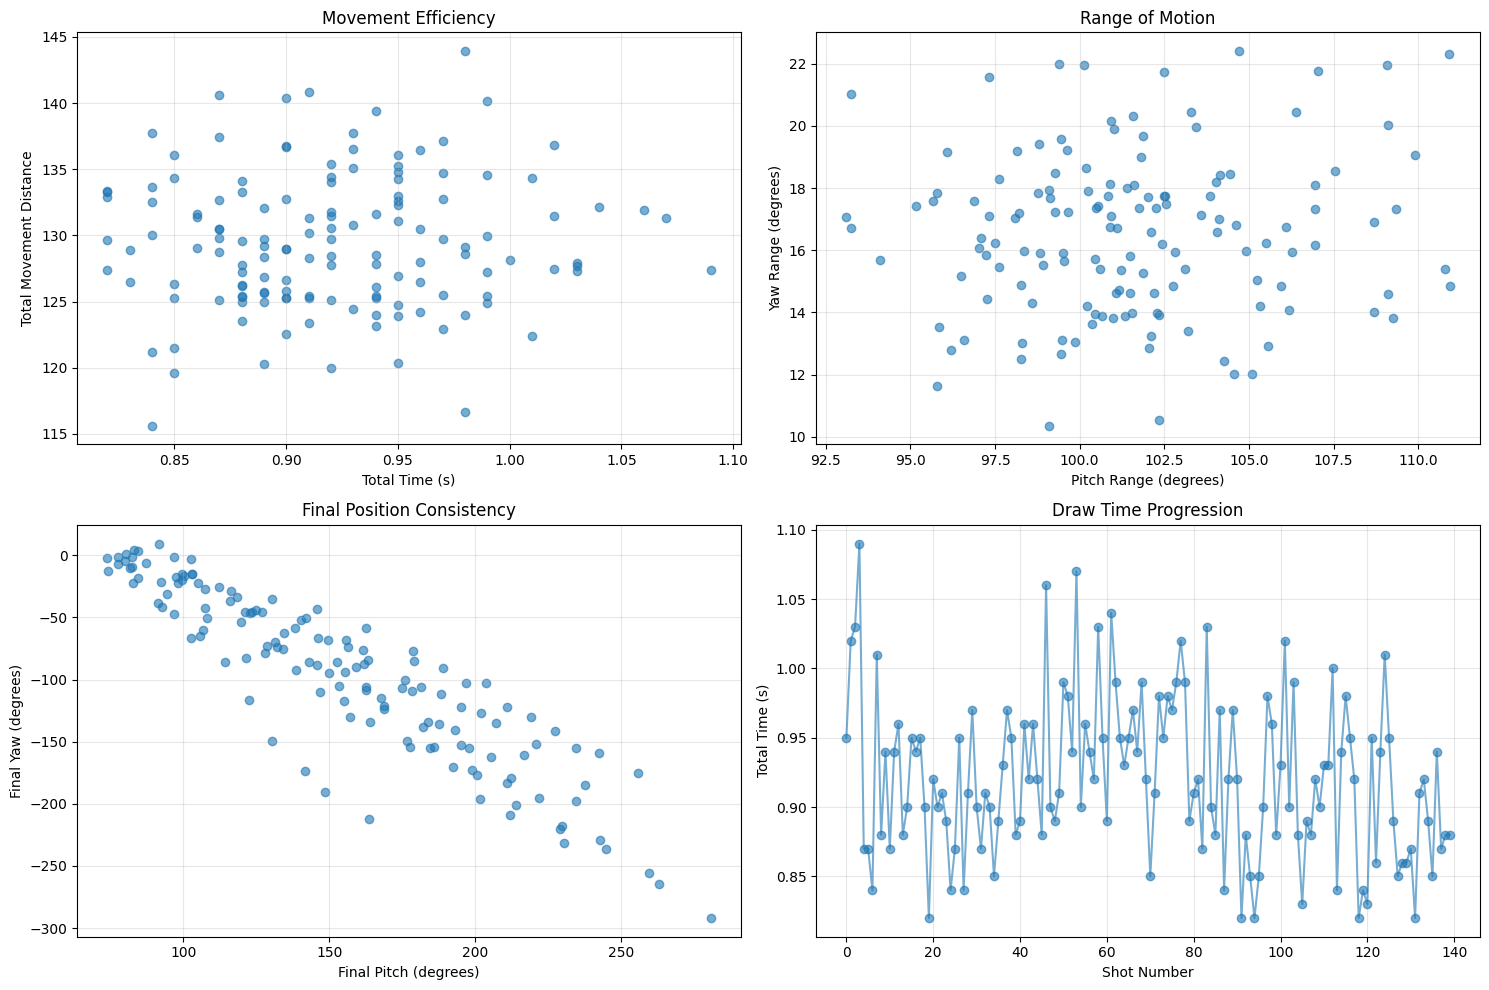

In [10]:
# Visualize stability metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total movement distance vs time
axes[0, 0].scatter(combined_stability['total_time'], combined_stability['total_distance'], alpha=0.6)
axes[0, 0].set_xlabel('Total Time (s)')
axes[0, 0].set_ylabel('Total Movement Distance')
axes[0, 0].set_title('Movement Efficiency')
axes[0, 0].grid(True, alpha=0.3)

# Range of motion
axes[0, 1].scatter(combined_stability['pitch_range'], combined_stability['yaw_range'], alpha=0.6)
axes[0, 1].set_xlabel('Pitch Range (degrees)')
axes[0, 1].set_ylabel('Yaw Range (degrees)')
axes[0, 1].set_title('Range of Motion')
axes[0, 1].grid(True, alpha=0.3)

# Final position consistency
axes[1, 0].scatter(combined_stability['final_pitch'], combined_stability['final_yaw'], alpha=0.6)
axes[1, 0].set_xlabel('Final Pitch (degrees)')
axes[1, 0].set_ylabel('Final Yaw (degrees)')
axes[1, 0].set_title('Final Position Consistency')
axes[1, 0].grid(True, alpha=0.3)

# Time progression
axes[1, 1].plot(combined_stability.index, combined_stability['total_time'], 'o-', alpha=0.6)
axes[1, 1].set_xlabel('Shot Number')
axes[1, 1].set_ylabel('Total Time (s)')
axes[1, 1].set_title('Draw Time Progression')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Advanced Timing Analysis

Detailed breakdown of timing components with statistical analysis and trends.

In [11]:
# Extract comprehensive timing data
timing_data = []

for session in all_sessions:
    session_info = session['session']
    for shot in session_info['shots']:
        timing_record = {
            'session_pk': session_info['pk'],
            'date': pd.to_datetime(session_info['date']),
            'shot_pk': shot['pk'],
            'grip_time': shot.get('grip_time', 0),
            'holster_pull_time': shot.get('holster_pull_time', 0),
            'horizontal_time': shot.get('horizontal_time', 0),
            'holster_target_time': shot.get('holster_target_time', 0),
            'horizontal_to_shot_time': shot.get('horizontal_to_shot_time', 0),
            'holster_total_time': shot.get('holster_total_time', 0)
        }
        timing_data.append(timing_record)

timing_df = pd.DataFrame(timing_data)
timing_df['date_only'] = timing_df['date'].dt.date

print(f"Total shots analyzed: {len(timing_df)}")
print(f"Date range: {timing_df['date'].min()} to {timing_df['date'].max()}")

Total shots analyzed: 140
Date range: 2025-06-25 18:48:34.258014+00:00 to 2025-06-27 16:31:31.270586+00:00


In [12]:
# Statistical summary of timing components
timing_components = ['grip_time', 'holster_pull_time', 'horizontal_time', 
                    'holster_target_time', 'horizontal_to_shot_time', 'holster_total_time']

summary_stats = timing_df[timing_components].describe()
summary_stats.loc['median'] = timing_df[timing_components].median()

print("Timing Statistics (in seconds):")
print(summary_stats.round(3))

Timing Statistics (in seconds):
        grip_time  holster_pull_time  horizontal_time  holster_target_time  \
count     140.000            140.000          140.000              140.000   
mean        0.293              0.093            0.294                0.017   
std         0.032              0.029            0.031                0.031   
min         0.190              0.000            0.230                0.000   
25%         0.280              0.090            0.280                0.000   
50%         0.290              0.100            0.290                0.000   
75%         0.310              0.100            0.300                0.020   
max         0.450              0.190            0.470                0.130   
median      0.290              0.100            0.290                0.000   

        horizontal_to_shot_time  holster_total_time  
count                   140.000             140.000  
mean                      0.225               0.921  
std                      

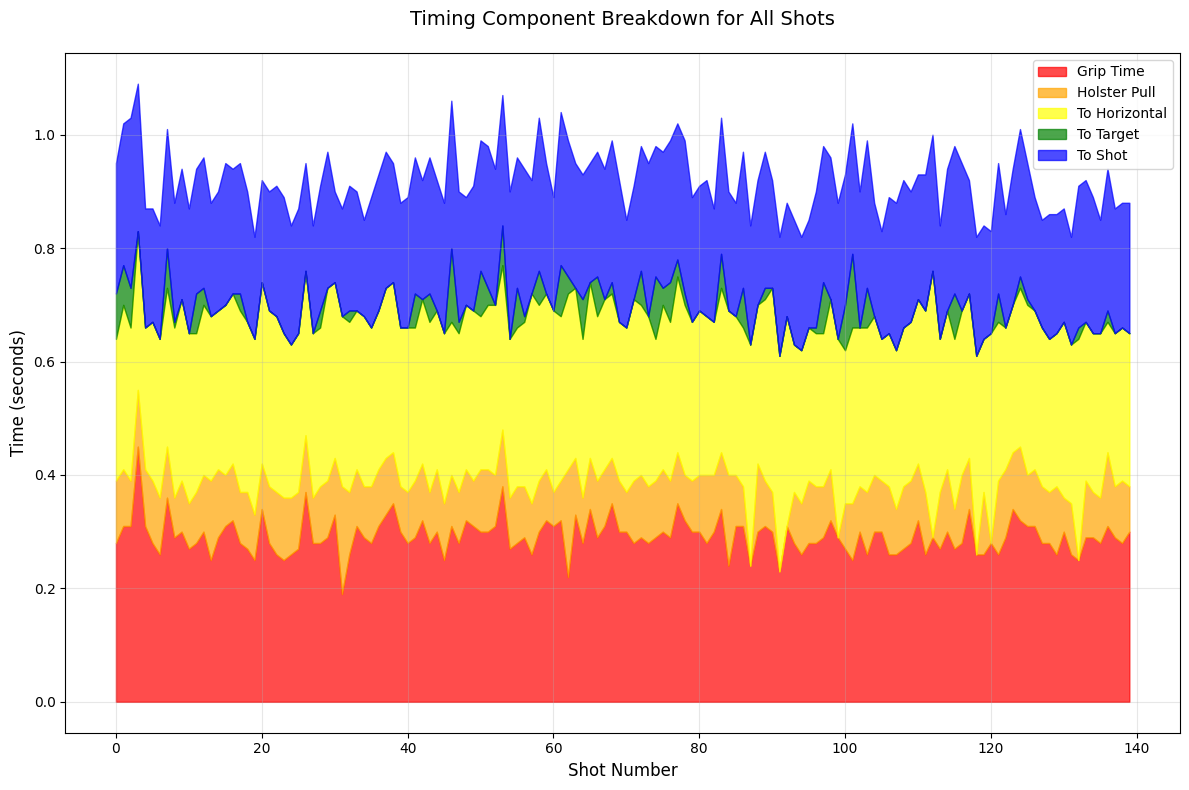

In [13]:
# Create a comprehensive timing breakdown visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate cumulative times for stacked bar chart
timing_df['cumulative_grip'] = timing_df['grip_time']
timing_df['cumulative_pull'] = timing_df['cumulative_grip'] + timing_df['holster_pull_time']
timing_df['cumulative_horizontal'] = timing_df['cumulative_pull'] + timing_df['horizontal_time']
timing_df['cumulative_target'] = timing_df['cumulative_horizontal'] + timing_df['holster_target_time']

shot_numbers = range(len(timing_df))

# Create stacked area chart
ax.fill_between(shot_numbers, 0, timing_df['cumulative_grip'], 
                alpha=0.7, color='red', label='Grip Time')
ax.fill_between(shot_numbers, timing_df['cumulative_grip'], timing_df['cumulative_pull'], 
                alpha=0.7, color='orange', label='Holster Pull')
ax.fill_between(shot_numbers, timing_df['cumulative_pull'], timing_df['cumulative_horizontal'], 
                alpha=0.7, color='yellow', label='To Horizontal')
ax.fill_between(shot_numbers, timing_df['cumulative_horizontal'], timing_df['cumulative_target'], 
                alpha=0.7, color='green', label='To Target')
ax.fill_between(shot_numbers, timing_df['cumulative_target'], timing_df['holster_total_time'], 
                alpha=0.7, color='blue', label='To Shot')

ax.set_xlabel('Shot Number', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Timing Component Breakdown for All Shots', fontsize=14, pad=20)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

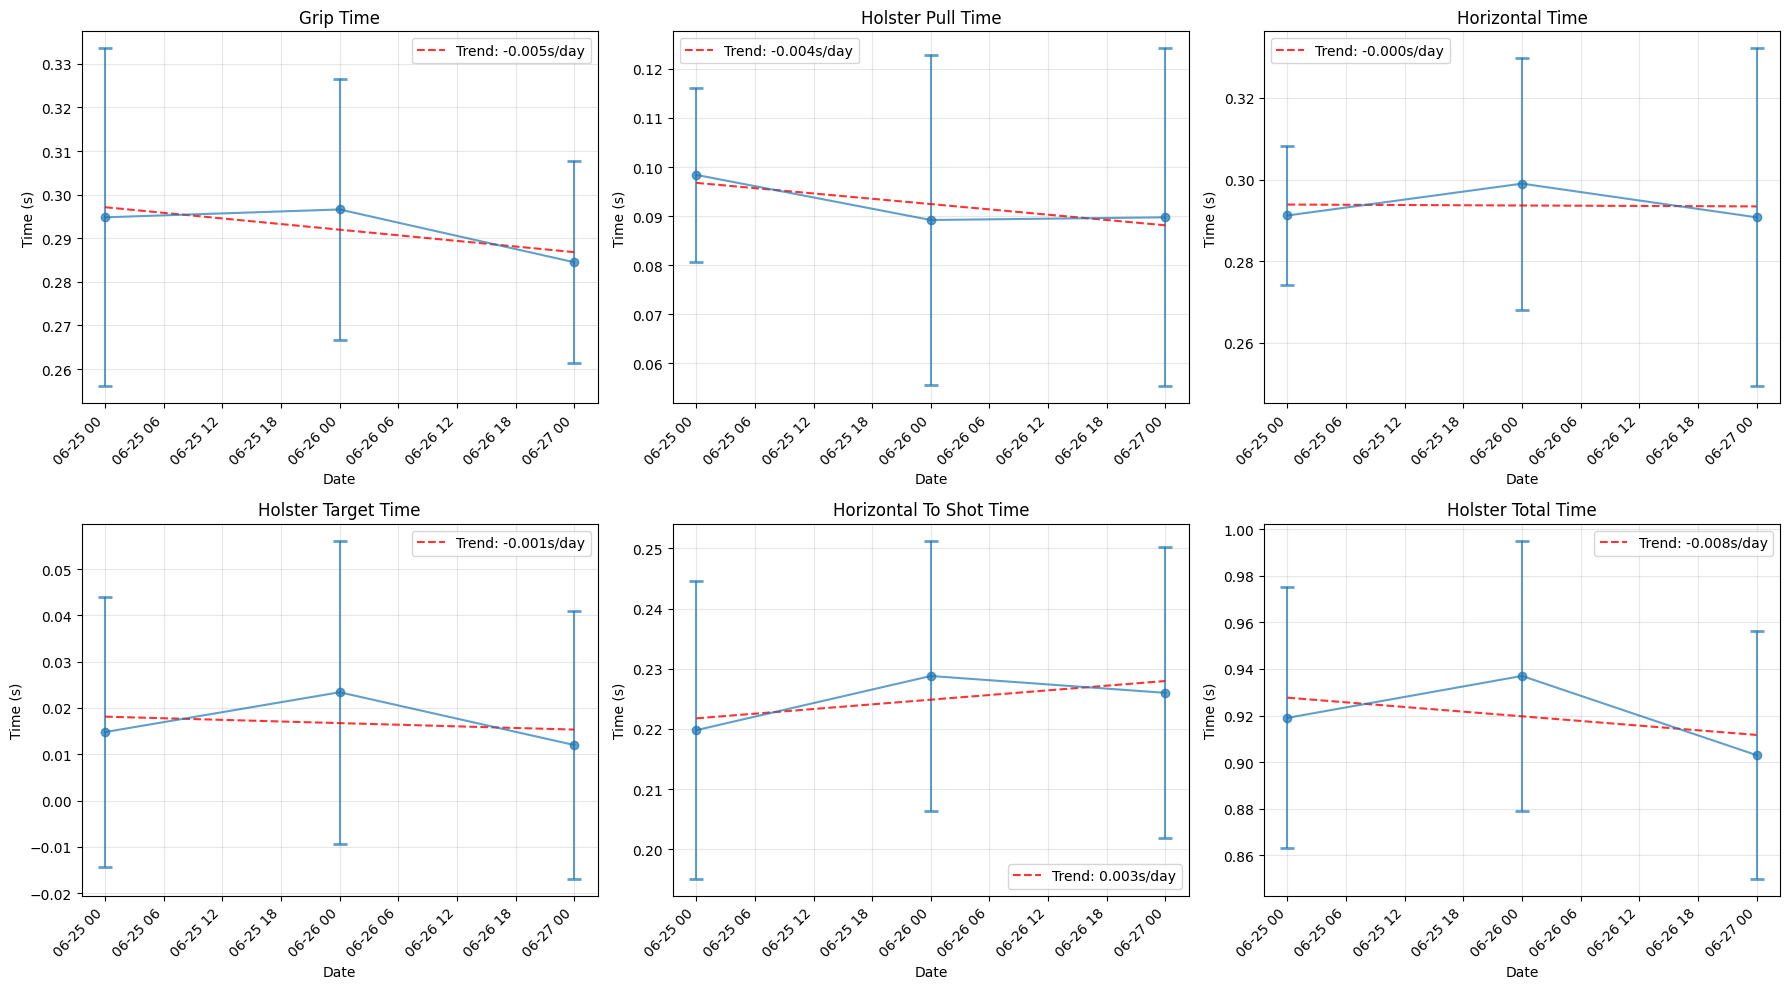

In [14]:
# Daily performance trends
daily_stats = timing_df.groupby('date_only')[timing_components].agg(['mean', 'std', 'min', 'max'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, component in enumerate(timing_components):
    ax = axes[idx]
    
    # Plot mean with error bars (std)
    dates = daily_stats.index
    means = daily_stats[component]['mean']
    stds = daily_stats[component]['std']
    
    ax.errorbar(dates, means, yerr=stds, marker='o', capsize=5, capthick=2, alpha=0.7)
    
    # Add trend line
    z = np.polyfit(range(len(dates)), means, 1)
    p = np.poly1d(z)
    ax.plot(dates, p(range(len(dates))), "r--", alpha=0.8, label=f'Trend: {z[0]:.3f}s/day')
    
    ax.set_title(component.replace('_', ' ').title())
    ax.set_xlabel('Date')
    ax.set_ylabel('Time (s)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Rotate x labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()

## Performance Insights Summary

Based on the analysis, here are key insights and recommendations for improvement.

In [15]:
# Generate performance insights
print("=== PERFORMANCE INSIGHTS ===")
print()

# Overall performance
avg_total_time = timing_df['holster_total_time'].mean()
best_time = timing_df['holster_total_time'].min()
print(f"Average Draw Time: {avg_total_time:.2f}s")
print(f"Best Draw Time: {best_time:.2f}s")
print(f"Improvement Potential: {avg_total_time - best_time:.2f}s")
print()

# Component breakdown
print("Time Distribution (% of total):")
for component in timing_components[:-1]:  # Exclude total time
    pct = (timing_df[component].mean() / avg_total_time) * 100
    print(f"  {component.replace('_', ' ').title()}: {pct:.1f}%")
print()

# Consistency analysis
print("Consistency (Coefficient of Variation):")
for component in timing_components:
    cv = (timing_df[component].std() / timing_df[component].mean()) * 100
    consistency = "Good" if cv < 10 else "Needs Improvement" if cv < 20 else "Poor"
    print(f"  {component.replace('_', ' ').title()}: {cv:.1f}% ({consistency})")
print()

# Identify weakest link
component_cvs = {comp: (timing_df[comp].std() / timing_df[comp].mean()) * 100 
                 for comp in timing_components[:-1]}
weakest_component = max(component_cvs, key=component_cvs.get)
print(f"Focus Area: {weakest_component.replace('_', ' ').title()} (highest variability)")

# Movement stability insights
if 'combined_stability' in locals():
    print("\n=== MOVEMENT STABILITY ===")
    print(f"Average Movement Distance: {combined_stability['total_distance'].mean():.1f} degrees")
    print(f"Average Final Position Variance: Pitch={combined_stability['pitch_std'].mean():.2f}°, Yaw={combined_stability['yaw_std'].mean():.2f}°")

=== PERFORMANCE INSIGHTS ===

Average Draw Time: 0.92s
Best Draw Time: 0.82s
Improvement Potential: 0.10s

Time Distribution (% of total):
  Grip Time: 31.8%
  Holster Pull Time: 10.1%
  Horizontal Time: 31.9%
  Holster Target Time: 1.9%
  Horizontal To Shot Time: 24.4%

Consistency (Coefficient of Variation):
  Grip Time: 10.9% (Needs Improvement)
  Holster Pull Time: 31.7% (Poor)
  Horizontal Time: 10.4% (Needs Improvement)
  Holster Target Time: 179.2% (Poor)
  Horizontal To Shot Time: 10.6% (Needs Improvement)
  Holster Total Time: 6.2% (Good)

Focus Area: Holster Target Time (highest variability)

=== MOVEMENT STABILITY ===
Average Movement Distance: 129.5 degrees
Average Final Position Variance: Pitch=35.97°, Yaw=4.21°
